<a href="https://colab.research.google.com/github/QWL55/Predicting_Migration_Flow/blob/main/notebook/CS224W_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CS224W - Final Project**

# Setup
First let us check which version of PyTorch you are running

In [1]:
# Install torch geometric
import os
import torch
torch_version = str(torch.__version__)
scatter_src = f"https://pytorch-geometric.com/whl/torch-{torch_version}.html"
sparse_src = f"https://pytorch-geometric.com/whl/torch-{torch_version}.html"
!pip install torch-scatter -f $scatter_src
!pip install torch-sparse -f $sparse_src
!pip install torch-geometric
!pip install -q git+https://github.com/snap-stanford/deepsnap.git
!pip install -U -q PyDrive

Looking in links: https://pytorch-geometric.com/whl/torch-2.5.1+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 55.3 MB/s eta 0:00:00
Looking in links: https://pytorch-geometric.com/whl/torch-2.5.1+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 42.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 41.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


# 1) GNN: Link Regression Task

In this section we will build our baseline graph neural network using PyTorch Geometric. Then we will apply it to the task of predicting the volume of migration flow (link regression).

Specifically, we will use GCN as the foundation for the graph neural network ([Kipf et al. (2017)](https://arxiv.org/pdf/1609.02907.pdf)). To do so, we will work with PyG's built-in `GCNConv` layer.

## Setup

In [2]:
import pandas as pd
import numpy as np
import copy
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score
# The PyG built-in GCNConv
import torch_geometric
from torch_geometric.nn import GCNConv
from torch_geometric.utils import negative_sampling
import torch_geometric.transforms as T

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# change the path to your project folder
os.chdir('/content/drive/MyDrive/Stanford SOC/CS224W/final_projects')

In [5]:
os.listdir()

['CS224W_Colab_2.ipynb',
 'dataset',
 'county_flow.csv',
 'county_node_info.csv',
 'flow_GraphSage.csv',
 'flow_GCN.csv',
 '.ipynb_checkpoints',
 'flow_GraphSage_full.csv',
 'flow_GCN_full.csv',
 'CS224W_Final_Project.ipynb']

## Load and Preprocess the Dataset

In [6]:
from torch_geometric.data import Data

# Load the datasets
county_flow_df = pd.read_csv('county_flow.csv', dtype={"fips_orig": str, "fips_dest": str})
county_node_df = pd.read_csv('county_node_info.csv', dtype={"GEOID": str})

# Step 1: Create a mapping from GEOID to index and
# map fips_orig and fips_dest in county_flow_df to indices
geo_to_index = {geo_id: idx for idx, geo_id in enumerate(county_node_df['GEOID'])}

county_flow_df['src'] = county_flow_df['fips_orig'].map(geo_to_index)
county_flow_df['dst'] = county_flow_df['fips_dest'].map(geo_to_index)

# Drop any rows with missing mappings (i.e., if a fips code doesn't exist in county_node_df)
county_flow_df = county_flow_df.dropna(subset=['src', 'dst']).astype({'src': int, 'dst': int})

# Step 2: Extract the edge list and label
edge_index_df = county_flow_df[['src', 'dst']]
edge_index = torch.tensor(edge_index_df.values.T, dtype=torch.long)

edge_labels = county_flow_df['flow'].values
edge_labels = torch.tensor(edge_labels, dtype=torch.long)

#Create a mapping dictionary from edge_index to edge_labels
edge_maps = {
    tuple(edge): label for edge, label in zip(edge_index.T.tolist(), edge_labels.tolist())
}

def load_process_data(feat_type):
    # Step 3: Create two versions of county_node_features
    if feat_type == 'full':
        # includes all columns except GEOID
        columns_to_drop = ['GEOID']
    elif feat_type == 'simple':
        # excludes columns with "feature" in their names
        columns_to_drop = ['GEOID'] + [col for col in county_node_df.columns if 'feature' in col.lower()]
    elif feat_type == 'pdfm':
        # include only pdfm features
        columns_to_drop = ['GEOID'] + [col for col in county_node_df.columns if 'feature' not in col.lower()]

    # select relevant features
    county_node_features = county_node_df.drop(columns=columns_to_drop, errors='ignore').values
    county_node_features = torch.tensor(county_node_features, dtype=torch.float)

    # Create PyG Data object
    data = Data(x=county_node_features, edge_index=edge_index, y=edge_labels,
                edge_label=edge_labels)
    data.num_node_features = county_node_features.shape[1]
    data.num_classes = 1

    return data

In [7]:
data_full = load_process_data('full')
data_simple = load_process_data('simple')
data_pdfm = load_process_data('pdfm')

print("Data with full features:")
print(data_full)
print("\nData with simple features:")
print(data_simple)
print("\nData with pdfm features:")
print(data_pdfm)

Data with full features:
Data(x=[3116, 339], edge_index=[2, 107568], y=[107568], edge_label=[107568], num_node_features=339, num_classes=1)

Data with simple features:
Data(x=[3116, 9], edge_index=[2, 107568], y=[107568], edge_label=[107568], num_node_features=9, num_classes=1)

Data with pdfm features:
Data(x=[3116, 330], edge_index=[2, 107568], y=[107568], edge_label=[107568], num_node_features=330, num_classes=1)


In [275]:
data_full

Data(x=[3116, 339], edge_index=[2, 107568], y=[107568], edge_label=[107568], num_node_features=339, num_classes=1)

In [9]:
# Data splitting
transform = T.Compose([T.ToSparseTensor(),
                       T.RandomLinkSplit(is_undirected=False,
                                         neg_sampling_ratio=0.5,
                                         split_labels=True)])

train_data, val_data, test_data = transform(data_simple)
#train_data, val_data, test_data = transform(data_simple)
print(train_data)

Data(x=[3116, 9], y=[75299], num_node_features=9, num_classes=1, adj_t=[3116, 3116, nnz=107568], edge_index=[2, 75299], pos_edge_label=[75299], pos_edge_label_index=[2, 75299], neg_edge_label=[37649], neg_edge_label_index=[2, 37649])


In [239]:
val_data = edge_mapping(val_data)

In [240]:
print(val_data.pos_edge_label.shape)

torch.Size([10756])


In [305]:
[k for k, v in geo_to_index.items() if v == 2792]

['050025']

In [304]:
val_data.pos_edge_label_index[0]

tensor([2792, 2662, 2436,  ..., 3000, 2199,  758])

In [308]:
filtered_df = county_node_df[(county_node_df['GEOID'] == "050025")]
print(filtered_df)

       GEOID  tot_pop  median_inc     unemp      pov    age_65  diveristy_idx  \
2792  050025    43609       50917  0.060457  0.13124  0.191726       0.121224   

      hou_burd  vote_share  crime_rate  ...  feature320    feature321  \
2792  0.001952    0.633532    0.028595  ...   -0.000013 -1.200000e-07   

      feature322  feature323    feature324  feature325  feature326  \
2792   -0.000314   -0.000869 -3.000000e-08   -0.000722        -0.0   

        feature327  feature328    feature329  
2792 -1.000000e-08        -0.0 -2.000000e-08  

[1 rows x 340 columns]


In [320]:
t1 = val_data.x[val_data.pos_edge_label_index[0]]
t2 = val_data.x[val_data.pos_edge_label_index[1]]

cat = torch.cat([t1, t2], dim=-1).shape

In [322]:
torch.cat([t1, t2], dim=1) == torch.cat([t1, t2], dim=-1)

tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]])

In [252]:
#val_data.pos_edge_label_index.T.tolist()
original_edges = val_data.pos_edge_label_index.T.tolist()
original_labels = val_data.pos_edge_label.tolist()

# Ensure alignment by creating a dictionary
edge_to_label = {tuple(edge): label for edge, label in zip(original_edges, original_labels)}

In [254]:
#edge_to_label

In [10]:
def edge_mapping(data):
    # Create a mapping of edge to label
    #original_edges = data.edge_label_index.T.tolist()
    #original_labels = data.pos_edge_label.tolist()

    # Ensure alignment by creating a dictionary
    #edge_to_label = {tuple(edge): label for edge, label in zip(original_edges, original_labels)}

    # Reassign labels in the order of pos_edge_label_index
    aligned_labels = []
    for edge in data.pos_edge_label_index.T.tolist():
        aligned_labels.append(edge_maps[tuple(edge)])

    # Convert aligned labels back to a tensor
    data.pos_edge_label = torch.tensor(aligned_labels, dtype=torch.float)

    return data

train_data = edge_mapping(train_data)

# Check if pos_edge_label corresponds to pos_edge_label_index
for i, (src, dst) in enumerate(train_data.pos_edge_label_index.T):
    label = train_data.pos_edge_label[i]
    print(f"Edge ({src.item()}, {dst.item()}) -> Label: {label.item()}")
    if i == 2:
        break

Edge (306, 2513) -> Label: 48.0
Edge (316, 1188) -> Label: 548.0
Edge (504, 473) -> Label: 104.0


In [300]:
train_data.pos_edge_label_index

tensor([[ 224, 2201, 2302,  ..., 2443,  722, 1640],
        [2964, 1040, 2334,  ..., 2446, 1020, 3109]])

In [301]:
train_data.pos_edge_label

tensor([ 47.,  42., 293.,  ...,  95.,  28.,  91.])

In [299]:
filtered_df = county_flow_df[(county_flow_df['src'] == 2201) & (county_flow_df['dst'] == 1040)]
print(filtered_df)

      fips_orig fips_dest  flow   src   dst
77098    041033    021107    42  2201  1040


In [96]:
county_node_df = pd.read_csv('county_node_info.csv', dtype={"GEOID": str})
county_flow_df = pd.read_csv('county_flow.csv', dtype={"fips_orig": str, "fips_dest": str})

# Step 1: Create a mapping from GEOID to index and
# map fips_orig and fips_dest in county_flow_df to indices
geo_to_index = {geo_id: idx for idx, geo_id in enumerate(county_node_df['GEOID'])}

county_flow_df['src'] = county_flow_df['fips_orig'].map(geo_to_index)
county_flow_df['dst'] = county_flow_df['fips_dest'].map(geo_to_index)


# Drop any rows with missing mappings (i.e., if a fips code doesn't exist in county_node_df)
county_flow_df = county_flow_df.dropna(subset=['src', 'dst']).astype({'src': int, 'dst': int})

# Model Building

In [11]:
import torch
import torch_scatter
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

from torch import Tensor
from typing import Union, Tuple, Optional
from torch_geometric.typing import (OptPairTensor, Adj, Size, NoneType,
                                    OptTensor)

from torch.nn import Parameter, Linear
from torch_sparse import SparseTensor, set_diag
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import remove_self_loops, add_self_loops, softmax

class GNNStack(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, args, emb=False):
        super(GNNStack, self).__init__()
        conv_model = self.build_conv_model(args.model_type)
        self.convs = nn.ModuleList()
        self.bns = nn.ModuleList()
        self.convs.append(conv_model(input_dim, hidden_dim))
        assert (args.num_layers >= 1), 'Number of layers is not >=1'
        for l in range(args.num_layers-1):
            self.convs.append(conv_model(args.heads * hidden_dim, hidden_dim))

        # post-message-passing
        # times 2 because we concatenate node embedding
        self.link_regressor = nn.Sequential(
            nn.Linear(2 * args.heads * hidden_dim, hidden_dim),
            nn.Dropout(args.dropout),
            nn.Linear(hidden_dim, output_dim))

        self.dropout = args.dropout

        for _ in range(args.num_layers):
            self.bns.append(torch.nn.BatchNorm1d(args.heads *hidden_dim))

        self.num_layers = args.num_layers
        self.prelu = nn.PReLU()
        self.emb = emb
        self.reset_parameters()

    def reset_parameters(self):
        # Reset parameters of convolutional layers
        for conv in self.convs:
            if hasattr(conv, 'reset_parameters'):
                conv.reset_parameters()
        # Reset parameters of link_regressor layers
        for layer in self.link_regressor:
            if isinstance(layer, nn.Linear):
                layer.reset_parameters()

        for bn in self.bns:
            bn.reset_parameters()


    def build_conv_model(self, model_type):
        if model_type == 'GraphSage':
            return GraphSage
        elif model_type == 'GCN':
            return GCNConv
        elif model_type == 'GAT':
            return GAT

    def forward(self, data):
        x, post_edge_index, neg_edge_index = data.x, data.pos_edge_label_index, data.neg_edge_label_index
        out = x

        edge_index = torch.cat([post_edge_index, neg_edge_index], dim=1)
        for i in range(self.num_layers):
            out = self.convs[i](out, post_edge_index)
            out = self.bns[i](out)
            out = self.prelu(out)
            output = F.dropout(out, p=self.dropout,training=self.training)

        if self.emb == True:
            return out

        return self.predict_edges(out, edge_index)

    def predict_edges(self, node_features, edge_index):
        # Extract source and destination node embeddings
        node_features_src = node_features[edge_index[0]]  # Source nodes
        node_features_dst = node_features[edge_index[1]]  # Destination nodes

        # Combine embeddings (e.g., using dot product or concatenation)
        edge_features = torch.cat([node_features_src, node_features_dst], dim=1)

        # Predict edge values (continuous outputs)
        edge_predictions = self.link_regressor(edge_features)

        return edge_predictions

    def loss(self, pred, label):
        return F.l1_loss(pred, label)

## GraphSage


In [13]:
class GraphSage(MessagePassing):

    def __init__(self, in_channels, out_channels, normalize = True,
                 bias = False, aggr="mean", **kwargs):
        super(GraphSage, self).__init__(**kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.normalize = normalize
        self.aggr = aggr
        ############################################################################
        # TODO: Your code here!
        # Define the (PyTorch) layers needed for the message and update functions below.
        # self.lin_l is the linear transformation that you apply to embedding
        #            for central node.
        # self.lin_r is the linear transformation that you apply to aggregated
        #            message from neighbors.
        # Don't forget the bias as part of the linear layers!
        # Our implementation is ~2 lines, but don't worry if you deviate from this.
        self.lin_l = nn.Linear(in_channels, out_channels, bias=bias)
        self.lin_r = nn.Linear(in_channels, out_channels, bias=bias)
        ############################################################################

        self.reset_parameters()

    def reset_parameters(self):
        self.lin_l.reset_parameters()
        self.lin_r.reset_parameters()

    def forward(self, x, edge_index, size = None):
        """"""

        ############################################################################
        # TODO: Your code here!
        # Implement message passing, as well as any post-processing (our update rule).
        # 1. Call the propagate function to conduct the message passing.
        #    1.1 See the description of propagate above or the following link for more information:
        #        https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html
        #    1.2 We will only use the representation for neighbor nodes (x_j), so by default
        #        we pass the same representation for central and neighbor nodes as x=(x, x).
        # 2. Update our node embedding with skip connection from the previous layer.
        # 3. If normalize is set, do L-2 normalization (defined in
        #    torch.nn.functional)
        out = self.propagate(edge_index, x=(x,x), size=size)
        out = self.lin_l(x) + self.lin_r(out)
        if self.normalize:
            out = F.normalize(out, p=2, dim=-1)

        return out

    def message(self, x_j):

        ############################################################################
        # TODO: Your code here!
        # Implement your message function here.
        # Hint: Look at the formulation of the mean aggregation function, focusing on
        # what message each neighboring node passes.
        #
        # Our implementation is ~1 lines, but don't worry if you deviate from this.
        out = x_j
        ############################################################################

        return out

    def aggregate(self, inputs, index, dim_size = None):
        # The axis along which to index number of nodes.
        node_dim = self.node_dim

        ############################################################################
        # TODO: Your code here!
        # Implement your aggregate function here.
        # See here as how to use torch_scatter.scatter:
        # https://pytorch-scatter.readthedocs.io/en/latest/functions/scatter.html#torch_scatter.scatter
        #
        # Our implementation is ~1 lines, but don't worry if you deviate from this.
        out = torch_scatter.scatter(inputs, index, dim=node_dim, reduce=self.aggr)

        ############################################################################

        return out

## GAT


In [12]:
class GAT(MessagePassing):

    def __init__(self, in_channels, out_channels, heads = 2,
                 negative_slope = 0.2, dropout = 0., **kwargs):
        super(GAT, self).__init__(node_dim=0, **kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.heads = heads
        self.negative_slope = negative_slope
        self.dropout = dropout

        ############################################################################
        # TODO: Your code here!
        # Define the layers needed for the message functions below.
        # self.lin_l is the linear transformation that you apply to embeddings
        # BEFORE message passing.
        #
        # Pay attention to dimensions of the linear layers, since we're using
        # multi-head attention.
        # Our implementation is ~1 lines, but don't worry if you deviate from this.
        self.lin_l = nn.Linear(in_channels, heads * out_channels, bias=False)
        ############################################################################

        self.lin_r = self.lin_l

        ############################################################################
        # TODO: Your code here!
        # Define the attention parameters \overrightarrow{a_l/r}^T in the above intro.
        # You have to deal with multi-head scenarios.
        # Use nn.Parameter instead of nn.Linear
        # Our implementation is ~2 lines, but don't worry if you deviate from this.
        self.att_l = nn.Parameter(torch.Tensor(1, heads, out_channels))
        self.att_r = nn.Parameter(torch.Tensor(1, heads, out_channels))
        ############################################################################

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.lin_l.weight)
        nn.init.xavier_uniform_(self.lin_r.weight)
        nn.init.xavier_uniform_(self.att_l)
        nn.init.xavier_uniform_(self.att_r)

    def forward(self, x, edge_index, size = None):

        H, C = self.heads, self.out_channels

        ############################################################################
        # TODO: Your code here!
        # Implement message passing, as well as any pre- and post-processing (our update rule).
        # 1. First apply linear transformation to node embeddings, and split that
        #    into multiple heads. We use the same representations for source and
        #    target nodes, but apply different linear weights (W_l and W_r)
        # 2. Calculate alpha vectors for central nodes (alpha_l) and neighbor nodes (alpha_r).
        # 3. Call propagate function to conduct the message passing.
        #    3.1 Remember to pass alpha = (alpha_l, alpha_r) as a parameter.
        #    3.2 See there for more information: https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html
        # 4. Transform the output back to the shape of [N, H * C].
        # Our implementation is ~5 lines, but don't worry if you deviate from this.
        x_l, x_r = self.lin_l(x).view(-1, H, C), self.lin_r(x).view(-1, H, C)
        alpha_l = (x_l * self.att_l).sum(dim=-1)
        alpha_r = (x_r * self.att_r).sum(dim=-1)

        out = self.propagate(edge_index, x=(x_l,x_r), alpha=(alpha_l, alpha_r), size=size)
        out = out.view(-1, H * C)
        ############################################################################

        return out


    def message(self, x_j, alpha_j, alpha_i, index, ptr, size_i):

        ############################################################################
        # TODO: Your code here!
        # Implement your message function. Putting the attention in message
        # instead of in update is a little tricky.
        # 1. Calculate the final attention weights using alpha_i and alpha_j,
        #    and apply leaky Relu.
        # 2. Calculate softmax over the neighbor nodes for all the nodes. Use
        #    torch_geometric.utils.softmax instead of the one in Pytorch.
        # 3. Apply dropout to attention weights (alpha).
        # 4. Multiply embeddings and attention weights. As a sanity check, the output
        #    should be of shape [E, H, C].
        # 5. ptr (LongTensor, optional): If given, computes the softmax based on
        #    sorted inputs in CSR representation. You can simply pass it to softmax.
        # 6. size_i: corresponds to the num_nodes variable input to the torch.geometric.softmax method
        # Our implementation is ~4-5 lines, but don't worry if you deviate from this.
        alpha = alpha_i + alpha_j
        out = F.leaky_relu(alpha, self.negative_slope)
        out = torch_geometric.utils.softmax(out, index, ptr, size_i)
        out = F.dropout(out, p=self.dropout, training=self.training)
        out = x_j * out.unsqueeze(-1)
        ############################################################################

        return out


    def aggregate(self, inputs, index, dim_size = None):

        ############################################################################
        # TODO: Your code here!
        # Implement your aggregate function here.
        # See here as how to use torch_scatter.scatter: https://pytorch-scatter.readthedocs.io/en/latest/_modules/torch_scatter/scatter.html
        # Pay attention to "reduce" parameter is different from that in GraphSage.
        # Our implementation is ~1 lines, but don't worry if you deviate from this.
        out = torch_scatter.scatter(inputs, index, dim=0, dim_size=dim_size, reduce='sum')
        ############################################################################

        return out

## Optimizer

In [14]:
import torch.optim as optim

def build_optimizer(args, params):
    weight_decay = args.weight_decay
    filter_fn = filter(lambda p : p.requires_grad, params)
    if args.opt == 'adam':
        optimizer = optim.Adam(filter_fn, lr=args.lr, weight_decay=weight_decay)
    elif args.opt == 'sgd':
        optimizer = optim.SGD(filter_fn, lr=args.lr, momentum=0.95, weight_decay=weight_decay)
    elif args.opt == 'rmsprop':
        optimizer = optim.RMSprop(filter_fn, lr=args.lr, weight_decay=weight_decay)
    elif args.opt == 'adagrad':
        optimizer = optim.Adagrad(filter_fn, lr=args.lr, weight_decay=weight_decay)
    if args.opt_scheduler == 'none':
        return None, optimizer
    elif args.opt_scheduler == 'step':
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=args.opt_decay_step, gamma=args.opt_decay_rate)
    elif args.opt_scheduler == 'cos':
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.opt_restart)
    return scheduler, optimizer

# Model Training and Evaluation

In [15]:
pip install torcheval

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 8.0 MB/s eta 0:00:00


In [28]:
from torch_geometric.data import DataLoader
from tqdm import trange
import matplotlib.pyplot as plt
from torcheval.metrics.functional import r2_score
#from sklearn.metrics import r2_score

def train(args):

    transform = T.Compose([T.ToSparseTensor(),
                           T.RandomLinkSplit(is_undirected=False,
                                             neg_sampling_ratio=0.5,
                                             split_labels=True)])
    dataset = args.dataset
    train_data, val_data, test_data = transform(dataset)
    train_data, val_data, test_data = edge_mapping(train_data), edge_mapping(val_data), edge_mapping(test_data)
    #print("Node task. test set size:", np.sum(dataset[0]['test_mask'].numpy()))
    #test_loader = loader = DataLoader(dataset, batch_size=args.batch_size, shuffle=False)

    # build model
    model = GNNStack(dataset.num_node_features, args.hidden_dim, dataset.num_classes,
                            args)
    scheduler, opt = build_optimizer(args, model.parameters())

    # train
    train_losses = []
    val_losses = []
    test_losses = []
    train_r2_scores = []
    val_r2_scores = []
    test_r2_scores = []

    best_val_loss = float('inf')
    best_model = None

    for epoch in trange(args.epochs, desc="Training", unit="Epochs"):
        model.train()
        #for batch in loader:
        opt.zero_grad()
        pred = model(train_data).squeeze(-1)
        label = torch.cat([train_data.pos_edge_label, train_data.neg_edge_label]).float()
        #label = train_data.pos_edge_label.float()
        #pred = pred[batch.train_mask]
        #label = label[batch.train_mask]
        label = torch.log1p(label)
        loss = model.loss(label, pred)
        loss.backward()
        opt.step()

        train_losses.append(loss.item())
        train_r2 = r2_score(pred, label).item()
        train_r2_scores.append(train_r2)

        val_loss, val_r2 = test(val_data, model)
        val_losses.append(val_loss)
        val_r2_scores.append(val_r2)

        print(
            f"Epoch {epoch + 1}: Training Loss {round(loss.item(), 5)}, "
            f"Training R2 {round(train_r2, 5)}",
            f"Validation Loss {round(val_loss, 5)}",
            f"Validation R2 {round(val_r2, 5)}"
        )

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = copy.deepcopy(model)

        test_loss, test_r2 = test(test_data, model)
        test_losses.append(test_loss)
        test_r2_scores.append(test_r2)

    return train_losses, val_losses, test_losses, best_model, test_data


def test(data, test_model, save_model_preds=False, model_type=None,
         feature_type=None):
    test_model.eval()

    #correct = 0
    # Note that Cora is only one graph!
    with torch.no_grad():
        # max(dim=1) returns values, indices tuple; only need indices
        pred = test_model(data).squeeze(-1)
        label = torch.cat([data.pos_edge_label, data.neg_edge_label]).float()
        label = torch.log1p(label)
        loss = test_model.loss(pred, label)
        r2 = r2_score(pred, label).item()
        #mask = data.val_mask if is_validation else data.test_mask
        # node classification: only evaluate on nodes in test set
        #pred = pred[mask]
        #label = label[mask]

        if save_model_preds:
            print ("Saving Model Predictions for Model Type", model_type)

            data = {}
            data['pred'] = pred.view(-1).cpu().detach().numpy()
            data['label'] = label.view(-1).cpu().detach().numpy()

            df = pd.DataFrame(data=data)
            # Save locally as csv
            df.to_csv('flow_' + model_type + "_" + feature_type +
                      '.csv', sep=',', index=False)
            # save model object as a pickle

        #correct += pred.eq(label).sum().item()

    #total = 0
    #for data in loader.dataset:
    #total += torch.sum(data.val_mask if is_validation else data.test_mask).item()

    return loss.item(), r2

class objectview(object):
    def __init__(self, d):
        self.__dict__ = d


In [44]:
def run_pipeline(arg):

    args = objectview(arg)
    train_losses, val_losses, test_losses, best_model, test_data = train(args)

        # Run test for our best model to save the predictions!
    best_loss, best_r2 = test(test_data, best_model, save_model_preds=True,
                              model_type=args.model_type, feature_type=args.feature_type)
    #print("Maximum test set accuracy: {0}".format(max(test_accs)))
    print("Minimum validation loss: {0}".format(min(val_losses)))
    print("Minimum test loss: {0}".format(min(test_losses)))
    print("Minimum test R2: {0}".format(best_r2))

    plt.title("Migration Flow Prediction L1 Loss")
    plt.plot(train_losses, label="training loss" + " - " + args.model_type)
    plt.plot(val_losses, label="validation loss" + " - " + args.model_type)
    plt.plot(test_losses, label="test loss" + " - " + args.model_type)
    plt.legend()
    plt.show()

## Running models

In [46]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
args = {
    'device': device,
    'num_layers': 1,
    'hidden_dim': 128,
    "out_dim": 1,
    'dropout': 0.2,
    'lr': 0.01,
    'epochs': 120,
    'model_type': "GCN",
    'batch_size': 32,
    'heads': 1,
    'opt': 'adam',
    'opt_scheduler': 'none',
    'opt_restart': 0,
    'weight_decay': 5e-3,
    'feature_type': 'full',
    'dataset': data_full
}

args_GraphSage = args.copy()
args_GraphSage["model_type"] = "GraphSage"

args_GAT = args.copy()
args_GAT["model_type"] = "GAT"
args_GAT["heads"] = 2

Training:   1%|          | 1/120 [00:01<03:53,  1.96s/Epochs]

Epoch 1: Training Loss 2.77772, Training R2 -1.46467 Validation Loss 2.73577 Validation R2 -1.44342


Training:   2%|▏         | 2/120 [00:03<03:31,  1.79s/Epochs]

Epoch 2: Training Loss 3.75502, Training R2 -3.99646 Validation Loss 2.79913 Validation R2 -1.56766


Training:   2%|▎         | 3/120 [00:05<03:28,  1.78s/Epochs]

Epoch 3: Training Loss 1.92847, Training R2 -0.03014 Validation Loss 2.79191 Validation R2 -1.51777


Training:   3%|▎         | 4/120 [00:06<03:06,  1.61s/Epochs]

Epoch 4: Training Loss 1.67092, Training R2 0.1974 Validation Loss 2.74903 Validation R2 -1.40615


Training:   4%|▍         | 5/120 [00:07<02:46,  1.45s/Epochs]

Epoch 5: Training Loss 1.70935, Training R2 0.13616 Validation Loss 2.71794 Validation R2 -1.34851


Training:   5%|▌         | 6/120 [00:09<02:35,  1.36s/Epochs]

Epoch 6: Training Loss 1.60181, Training R2 0.20734 Validation Loss 2.71116 Validation R2 -1.35127


Training:   6%|▌         | 7/120 [00:10<02:27,  1.31s/Epochs]

Epoch 7: Training Loss 1.47206, Training R2 0.29921 Validation Loss 2.70621 Validation R2 -1.34535


Training:   7%|▋         | 8/120 [00:11<02:23,  1.28s/Epochs]

Epoch 8: Training Loss 1.595, Training R2 0.21798 Validation Loss 2.67794 Validation R2 -1.28081


Training:   8%|▊         | 9/120 [00:12<02:19,  1.26s/Epochs]

Epoch 9: Training Loss 1.49162, Training R2 0.27087 Validation Loss 2.63363 Validation R2 -1.17598


Training:   8%|▊         | 10/120 [00:13<02:17,  1.25s/Epochs]

Epoch 10: Training Loss 1.42463, Training R2 0.30215 Validation Loss 2.60623 Validation R2 -1.09982


Training:   9%|▉         | 11/120 [00:15<02:13,  1.23s/Epochs]

Epoch 11: Training Loss 1.47283, Training R2 0.27452 Validation Loss 2.60871 Validation R2 -1.08707


Training:  10%|█         | 12/120 [00:16<02:20,  1.30s/Epochs]

Epoch 12: Training Loss 1.40364, Training R2 0.34072 Validation Loss 2.62543 Validation R2 -1.11006


Training:  11%|█         | 13/120 [00:18<02:30,  1.40s/Epochs]

Epoch 13: Training Loss 1.40654, Training R2 0.36215 Validation Loss 2.62709 Validation R2 -1.11012


Training:  12%|█▏        | 14/120 [00:19<02:40,  1.51s/Epochs]

Epoch 14: Training Loss 1.45485, Training R2 0.34117 Validation Loss 2.60229 Validation R2 -1.06281


Training:  12%|█▎        | 15/120 [00:21<02:32,  1.45s/Epochs]

Epoch 15: Training Loss 1.40062, Training R2 0.36172 Validation Loss 2.56084 Validation R2 -0.98987


Training:  13%|█▎        | 16/120 [00:22<02:24,  1.39s/Epochs]

Epoch 16: Training Loss 1.37512, Training R2 0.35743 Validation Loss 2.52653 Validation R2 -0.93686


Training:  14%|█▍        | 17/120 [00:23<02:17,  1.33s/Epochs]

Epoch 17: Training Loss 1.40552, Training R2 0.32341 Validation Loss 2.51478 Validation R2 -0.9266


Training:  15%|█▌        | 18/120 [00:24<02:12,  1.30s/Epochs]

Epoch 18: Training Loss 1.38294, Training R2 0.33562 Validation Loss 2.51978 Validation R2 -0.9438


Training:  16%|█▌        | 19/120 [00:26<02:07,  1.26s/Epochs]

Epoch 19: Training Loss 1.36854, Training R2 0.34694 Validation Loss 2.52149 Validation R2 -0.94904


Training:  17%|█▋        | 20/120 [00:27<02:04,  1.24s/Epochs]

Epoch 20: Training Loss 1.39516, Training R2 0.33172 Validation Loss 2.50493 Validation R2 -0.91365


Training:  18%|█▊        | 21/120 [00:28<02:01,  1.22s/Epochs]

Epoch 21: Training Loss 1.38629, Training R2 0.33781 Validation Loss 2.4711 Validation R2 -0.84151


Training:  18%|█▊        | 22/120 [00:29<01:59,  1.22s/Epochs]

Epoch 22: Training Loss 1.35907, Training R2 0.35832 Validation Loss 2.43337 Validation R2 -0.76061


Training:  19%|█▉        | 23/120 [00:31<02:04,  1.28s/Epochs]

Epoch 23: Training Loss 1.36383, Training R2 0.35625 Validation Loss 2.4086 Validation R2 -0.70319


Training:  20%|██        | 24/120 [00:32<02:15,  1.41s/Epochs]

Epoch 24: Training Loss 1.37217, Training R2 0.35485 Validation Loss 2.40206 Validation R2 -0.68041


Training:  21%|██        | 25/120 [00:34<02:22,  1.50s/Epochs]

Epoch 25: Training Loss 1.35882, Training R2 0.3699 Validation Loss 2.40313 Validation R2 -0.67688


Training:  22%|██▏       | 26/120 [00:36<02:20,  1.49s/Epochs]

Epoch 26: Training Loss 1.35912, Training R2 0.37495 Validation Loss 2.39532 Validation R2 -0.66552


Training:  22%|██▎       | 27/120 [00:37<02:10,  1.40s/Epochs]

Epoch 27: Training Loss 1.36786, Training R2 0.37135 Validation Loss 2.3691 Validation R2 -0.6297


Training:  23%|██▎       | 28/120 [00:38<02:04,  1.35s/Epochs]

Epoch 28: Training Loss 1.35706, Training R2 0.37533 Validation Loss 2.32856 Validation R2 -0.5758


Training:  24%|██▍       | 29/120 [00:40<02:07,  1.40s/Epochs]

Epoch 29: Training Loss 1.34702, Training R2 0.37567 Validation Loss 2.28898 Validation R2 -0.52579


Training:  25%|██▌       | 30/120 [00:41<02:10,  1.45s/Epochs]

Epoch 30: Training Loss 1.35462, Training R2 0.36433 Validation Loss 2.26563 Validation R2 -0.4978


Training:  26%|██▌       | 31/120 [00:42<02:01,  1.37s/Epochs]

Epoch 31: Training Loss 1.35535, Training R2 0.36144 Validation Loss 2.26006 Validation R2 -0.49145


Training:  27%|██▋       | 32/120 [00:43<01:56,  1.33s/Epochs]

Epoch 32: Training Loss 1.34697, Training R2 0.36851 Validation Loss 2.259 Validation R2 -0.48809


Training:  28%|██▊       | 33/120 [00:45<01:52,  1.29s/Epochs]

Epoch 33: Training Loss 1.34989, Training R2 0.36989 Validation Loss 2.24688 Validation R2 -0.46614


Training:  28%|██▊       | 34/120 [00:46<02:00,  1.40s/Epochs]

Epoch 34: Training Loss 1.3532, Training R2 0.3693 Validation Loss 2.21798 Validation R2 -0.41891


Training:  29%|██▉       | 35/120 [00:48<02:05,  1.47s/Epochs]

Epoch 35: Training Loss 1.34537, Training R2 0.37407 Validation Loss 2.1798 Validation R2 -0.35923


Training:  30%|███       | 36/120 [00:50<02:09,  1.54s/Epochs]

Epoch 36: Training Loss 1.34303, Training R2 0.37492 Validation Loss 2.14551 Validation R2 -0.30603


Training:  31%|███       | 37/120 [00:51<01:58,  1.43s/Epochs]

Epoch 37: Training Loss 1.34925, Training R2 0.37059 Validation Loss 2.12353 Validation R2 -0.27025


Training:  32%|███▏      | 38/120 [00:52<01:52,  1.37s/Epochs]

Epoch 38: Training Loss 1.34613, Training R2 0.37477 Validation Loss 2.11018 Validation R2 -0.24795


Training:  32%|███▎      | 39/120 [00:54<01:54,  1.41s/Epochs]

Epoch 39: Training Loss 1.34422, Training R2 0.37823 Validation Loss 2.09194 Validation R2 -0.22388


Training:  33%|███▎      | 40/120 [00:55<01:48,  1.36s/Epochs]

Epoch 40: Training Loss 1.34613, Training R2 0.37871 Validation Loss 2.05641 Validation R2 -0.18402


Training:  34%|███▍      | 41/120 [00:56<01:44,  1.32s/Epochs]

Epoch 41: Training Loss 1.34536, Training R2 0.37713 Validation Loss 2.00466 Validation R2 -0.13002


Training:  35%|███▌      | 42/120 [00:57<01:40,  1.29s/Epochs]

Epoch 42: Training Loss 1.34171, Training R2 0.37659 Validation Loss 1.94815 Validation R2 -0.07387


Training:  36%|███▌      | 43/120 [00:59<01:37,  1.27s/Epochs]

Epoch 43: Training Loss 1.34214, Training R2 0.37263 Validation Loss 1.90337 Validation R2 -0.02976


Training:  37%|███▋      | 44/120 [01:00<01:38,  1.29s/Epochs]

Epoch 44: Training Loss 1.34318, Training R2 0.37069 Validation Loss 1.87404 Validation R2 0.00102


Training:  38%|███▊      | 45/120 [01:02<01:45,  1.41s/Epochs]

Epoch 45: Training Loss 1.34078, Training R2 0.37327 Validation Loss 1.85092 Validation R2 0.02717
Epoch 46: Training Loss 1.34085, Training R2 0.37572 Validation Loss 1.81955 Validation R2 0.06022


Training:  39%|███▉      | 47/120 [01:05<01:45,  1.44s/Epochs]

Epoch 47: Training Loss 1.34143, Training R2 0.37631 Validation Loss 1.7745 Validation R2 0.10264


Training:  40%|████      | 48/120 [01:06<01:39,  1.38s/Epochs]

Epoch 48: Training Loss 1.33968, Training R2 0.37819 Validation Loss 1.72229 Validation R2 0.14703


Training:  41%|████      | 49/120 [01:07<01:34,  1.33s/Epochs]

Epoch 49: Training Loss 1.33914, Training R2 0.37794 Validation Loss 1.67889 Validation R2 0.18194


Training:  42%|████▏     | 50/120 [01:08<01:31,  1.30s/Epochs]

Epoch 50: Training Loss 1.33909, Training R2 0.37796 Validation Loss 1.65098 Validation R2 0.20439
Epoch 51: Training Loss 1.33815, Training R2 0.38031 Validation Loss 1.63118 Validation R2 0.21941


Training:  43%|████▎     | 52/120 [01:11<01:37,  1.43s/Epochs]

Epoch 52: Training Loss 1.33808, Training R2 0.38138 Validation Loss 1.60627 Validation R2 0.2346


Training:  44%|████▍     | 53/120 [01:12<01:31,  1.36s/Epochs]

Epoch 53: Training Loss 1.33871, Training R2 0.38106 Validation Loss 1.56938 Validation R2 0.25392
Epoch 54: Training Loss 1.33667, Training R2 0.38009 Validation Loss 1.52722 Validation R2 0.27451


Training:  46%|████▌     | 55/120 [01:15<01:34,  1.45s/Epochs]

Epoch 55: Training Loss 1.33646, Training R2 0.37857 Validation Loss 1.49395 Validation R2 0.29063
Epoch 56: Training Loss 1.33714, Training R2 0.37657 Validation Loss 1.47402 Validation R2 0.3012


Training:  48%|████▊     | 57/120 [01:19<01:36,  1.54s/Epochs]

Epoch 57: Training Loss 1.3368, Training R2 0.37623 Validation Loss 1.46262 Validation R2 0.30859


Training:  48%|████▊     | 58/120 [01:20<01:29,  1.45s/Epochs]

Epoch 58: Training Loss 1.33615, Training R2 0.37773 Validation Loss 1.45021 Validation R2 0.31682


Training:  49%|████▉     | 59/120 [01:21<01:23,  1.37s/Epochs]

Epoch 59: Training Loss 1.33672, Training R2 0.3783 Validation Loss 1.43247 Validation R2 0.3273


Training:  50%|█████     | 60/120 [01:22<01:20,  1.34s/Epochs]

Epoch 60: Training Loss 1.33511, Training R2 0.37892 Validation Loss 1.41348 Validation R2 0.33803


Training:  51%|█████     | 61/120 [01:24<01:17,  1.31s/Epochs]

Epoch 61: Training Loss 1.33474, Training R2 0.37922 Validation Loss 1.39894 Validation R2 0.34646


Training:  52%|█████▏    | 62/120 [01:25<01:14,  1.29s/Epochs]

Epoch 62: Training Loss 1.33574, Training R2 0.37846 Validation Loss 1.3907 Validation R2 0.35192


Training:  52%|█████▎    | 63/120 [01:26<01:11,  1.26s/Epochs]

Epoch 63: Training Loss 1.33436, Training R2 0.3802 Validation Loss 1.3848 Validation R2 0.35564


Training:  53%|█████▎    | 64/120 [01:27<01:10,  1.26s/Epochs]

Epoch 64: Training Loss 1.33469, Training R2 0.38084 Validation Loss 1.37742 Validation R2 0.35894


Training:  54%|█████▍    | 65/120 [01:29<01:10,  1.28s/Epochs]

Epoch 65: Training Loss 1.33499, Training R2 0.38018 Validation Loss 1.36782 Validation R2 0.36243


Training:  55%|█████▌    | 66/120 [01:30<01:16,  1.41s/Epochs]

Epoch 66: Training Loss 1.33435, Training R2 0.37968 Validation Loss 1.35864 Validation R2 0.3656


Training:  56%|█████▌    | 67/120 [01:32<01:19,  1.51s/Epochs]

Epoch 67: Training Loss 1.3339, Training R2 0.37844 Validation Loss 1.35226 Validation R2 0.36836


Training:  57%|█████▋    | 68/120 [01:34<01:15,  1.46s/Epochs]

Epoch 68: Training Loss 1.33374, Training R2 0.37824 Validation Loss 1.34844 Validation R2 0.37107


Training:  57%|█████▊    | 69/120 [01:35<01:10,  1.38s/Epochs]

Epoch 69: Training Loss 1.33325, Training R2 0.37909 Validation Loss 1.34589 Validation R2 0.37374


Training:  58%|█████▊    | 70/120 [01:36<01:06,  1.34s/Epochs]

Epoch 70: Training Loss 1.33329, Training R2 0.37985 Validation Loss 1.34355 Validation R2 0.37593


Training:  59%|█████▉    | 71/120 [01:37<01:04,  1.31s/Epochs]

Epoch 71: Training Loss 1.33218, Training R2 0.38138 Validation Loss 1.34129 Validation R2 0.37744


Training:  60%|██████    | 72/120 [01:38<01:01,  1.29s/Epochs]

Epoch 72: Training Loss 1.33252, Training R2 0.38111 Validation Loss 1.33928 Validation R2 0.3782


Training:  61%|██████    | 73/120 [01:40<00:59,  1.27s/Epochs]

Epoch 73: Training Loss 1.33208, Training R2 0.38141 Validation Loss 1.33751 Validation R2 0.37881


Training:  62%|██████▏   | 74/120 [01:41<00:58,  1.26s/Epochs]

Epoch 74: Training Loss 1.33259, Training R2 0.38073 Validation Loss 1.33567 Validation R2 0.37939


Training:  62%|██████▎   | 75/120 [01:42<00:55,  1.24s/Epochs]

Epoch 75: Training Loss 1.33152, Training R2 0.38164 Validation Loss 1.33405 Validation R2 0.37958


Training:  63%|██████▎   | 76/120 [01:44<00:59,  1.35s/Epochs]

Epoch 76: Training Loss 1.3311, Training R2 0.38146 Validation Loss 1.3331 Validation R2 0.37901


Training:  64%|██████▍   | 77/120 [01:45<01:02,  1.46s/Epochs]

Epoch 77: Training Loss 1.33179, Training R2 0.38034 Validation Loss 1.33288 Validation R2 0.37811


Training:  65%|██████▌   | 78/120 [01:47<01:05,  1.57s/Epochs]

Epoch 78: Training Loss 1.3315, Training R2 0.38063 Validation Loss 1.3329 Validation R2 0.37782


Training:  66%|██████▌   | 79/120 [01:48<01:00,  1.47s/Epochs]

Epoch 79: Training Loss 1.33127, Training R2 0.38002 Validation Loss 1.33289 Validation R2 0.37823


Training:  67%|██████▋   | 80/120 [01:50<00:56,  1.40s/Epochs]

Epoch 80: Training Loss 1.3305, Training R2 0.38062 Validation Loss 1.3332 Validation R2 0.37861


Training:  68%|██████▊   | 81/120 [01:51<00:52,  1.34s/Epochs]

Epoch 81: Training Loss 1.33076, Training R2 0.38109 Validation Loss 1.33375 Validation R2 0.3786


Training:  68%|██████▊   | 82/120 [01:52<00:49,  1.31s/Epochs]

Epoch 82: Training Loss 1.33115, Training R2 0.38082 Validation Loss 1.33436 Validation R2 0.37816


Training:  69%|██████▉   | 83/120 [01:53<00:46,  1.27s/Epochs]

Epoch 83: Training Loss 1.33075, Training R2 0.38113 Validation Loss 1.33436 Validation R2 0.37808


Training:  70%|███████   | 84/120 [01:55<00:45,  1.26s/Epochs]

Epoch 84: Training Loss 1.32925, Training R2 0.38173 Validation Loss 1.33375 Validation R2 0.37826


Training:  71%|███████   | 85/120 [01:56<00:43,  1.25s/Epochs]

Epoch 85: Training Loss 1.32988, Training R2 0.38124 Validation Loss 1.33287 Validation R2 0.37845


Training:  72%|███████▏  | 86/120 [01:57<00:42,  1.25s/Epochs]

Epoch 86: Training Loss 1.33009, Training R2 0.38121 Validation Loss 1.33225 Validation R2 0.37838


Training:  72%|███████▎  | 87/120 [01:59<00:44,  1.35s/Epochs]

Epoch 87: Training Loss 1.32948, Training R2 0.38143 Validation Loss 1.33205 Validation R2 0.37801
Epoch 88: Training Loss 1.32939, Training R2 0.38109 Validation Loss 1.33224 Validation R2 0.37762


Training:  74%|███████▍  | 89/120 [02:02<00:48,  1.55s/Epochs]

Epoch 89: Training Loss 1.32959, Training R2 0.38063 Validation Loss 1.33181 Validation R2 0.37832


Training:  75%|███████▌  | 90/120 [02:03<00:43,  1.46s/Epochs]

Epoch 90: Training Loss 1.32824, Training R2 0.38144 Validation Loss 1.33117 Validation R2 0.37935


Training:  76%|███████▌  | 91/120 [02:05<00:40,  1.38s/Epochs]

Epoch 91: Training Loss 1.32788, Training R2 0.38212 Validation Loss 1.33135 Validation R2 0.37939


Training:  77%|███████▋  | 92/120 [02:06<00:37,  1.34s/Epochs]

Epoch 92: Training Loss 1.32805, Training R2 0.38228 Validation Loss 1.33251 Validation R2 0.37822


Training:  78%|███████▊  | 93/120 [02:07<00:35,  1.30s/Epochs]

Epoch 93: Training Loss 1.32823, Training R2 0.38191 Validation Loss 1.33276 Validation R2 0.37789


Training:  78%|███████▊  | 94/120 [02:08<00:33,  1.29s/Epochs]

Epoch 94: Training Loss 1.32696, Training R2 0.38228 Validation Loss 1.33174 Validation R2 0.37874


Training:  79%|███████▉  | 95/120 [02:10<00:31,  1.27s/Epochs]

Epoch 95: Training Loss 1.32771, Training R2 0.38188 Validation Loss 1.33108 Validation R2 0.37917


Training:  80%|████████  | 96/120 [02:11<00:30,  1.27s/Epochs]

Epoch 96: Training Loss 1.3275, Training R2 0.38219 Validation Loss 1.33146 Validation R2 0.3784


Training:  81%|████████  | 97/120 [02:12<00:28,  1.25s/Epochs]

Epoch 97: Training Loss 1.32699, Training R2 0.38201 Validation Loss 1.33233 Validation R2 0.37727


Training:  82%|████████▏ | 98/120 [02:14<00:30,  1.38s/Epochs]

Epoch 98: Training Loss 1.32697, Training R2 0.38157 Validation Loss 1.33152 Validation R2 0.37813


Training:  82%|████████▎ | 99/120 [02:15<00:30,  1.47s/Epochs]

Epoch 99: Training Loss 1.32656, Training R2 0.38212 Validation Loss 1.33031 Validation R2 0.37944


Training:  83%|████████▎ | 100/120 [02:17<00:31,  1.55s/Epochs]

Epoch 100: Training Loss 1.32581, Training R2 0.38318 Validation Loss 1.33074 Validation R2 0.37889


Training:  84%|████████▍ | 101/120 [02:18<00:27,  1.44s/Epochs]

Epoch 101: Training Loss 1.32647, Training R2 0.3825 Validation Loss 1.33174 Validation R2 0.37766


Training:  85%|████████▌ | 102/120 [02:20<00:24,  1.38s/Epochs]

Epoch 102: Training Loss 1.32615, Training R2 0.38214 Validation Loss 1.3313 Validation R2 0.37785


Training:  86%|████████▌ | 103/120 [02:21<00:22,  1.33s/Epochs]

Epoch 103: Training Loss 1.3257, Training R2 0.3824 Validation Loss 1.33028 Validation R2 0.37863


Training:  87%|████████▋ | 104/120 [02:22<00:21,  1.32s/Epochs]

Epoch 104: Training Loss 1.32565, Training R2 0.38263 Validation Loss 1.33047 Validation R2 0.37815


Training:  88%|████████▊ | 105/120 [02:23<00:19,  1.29s/Epochs]

Epoch 105: Training Loss 1.32557, Training R2 0.38243 Validation Loss 1.33143 Validation R2 0.37686


Training:  88%|████████▊ | 106/120 [02:24<00:17,  1.28s/Epochs]

Epoch 106: Training Loss 1.32563, Training R2 0.38164 Validation Loss 1.33144 Validation R2 0.37683


Training:  89%|████████▉ | 107/120 [02:26<00:16,  1.25s/Epochs]

Epoch 107: Training Loss 1.32497, Training R2 0.38219 Validation Loss 1.33075 Validation R2 0.37762


Training:  90%|█████████ | 108/120 [02:27<00:15,  1.25s/Epochs]

Epoch 108: Training Loss 1.32517, Training R2 0.38227 Validation Loss 1.33111 Validation R2 0.37719


Training:  91%|█████████ | 109/120 [02:29<00:15,  1.37s/Epochs]

Epoch 109: Training Loss 1.32593, Training R2 0.38188 Validation Loss 1.33125 Validation R2 0.37697
Epoch 110: Training Loss 1.32551, Training R2 0.38159 Validation Loss 1.33099 Validation R2 0.37716


Training:  92%|█████████▎| 111/120 [02:32<00:13,  1.51s/Epochs]

Epoch 111: Training Loss 1.32468, Training R2 0.38213 Validation Loss 1.33104 Validation R2 0.377


Training:  93%|█████████▎| 112/120 [02:33<00:11,  1.43s/Epochs]

Epoch 112: Training Loss 1.32529, Training R2 0.38194 Validation Loss 1.33079 Validation R2 0.377


Training:  94%|█████████▍| 113/120 [02:34<00:09,  1.35s/Epochs]

Epoch 113: Training Loss 1.32497, Training R2 0.38206 Validation Loss 1.33061 Validation R2 0.37691


Training:  95%|█████████▌| 114/120 [02:36<00:07,  1.31s/Epochs]

Epoch 114: Training Loss 1.32524, Training R2 0.38156 Validation Loss 1.33043 Validation R2 0.37673


Training:  96%|█████████▌| 115/120 [02:37<00:06,  1.29s/Epochs]

Epoch 115: Training Loss 1.32415, Training R2 0.38209 Validation Loss 1.33075 Validation R2 0.37611


Training:  97%|█████████▋| 116/120 [02:38<00:05,  1.28s/Epochs]

Epoch 116: Training Loss 1.32388, Training R2 0.38184 Validation Loss 1.33082 Validation R2 0.3759


Training:  98%|█████████▊| 117/120 [02:39<00:03,  1.26s/Epochs]

Epoch 117: Training Loss 1.32389, Training R2 0.38164 Validation Loss 1.33034 Validation R2 0.37644


Training:  98%|█████████▊| 118/120 [02:41<00:02,  1.27s/Epochs]

Epoch 118: Training Loss 1.32354, Training R2 0.38197 Validation Loss 1.3309 Validation R2 0.37577


Training:  99%|█████████▉| 119/120 [02:42<00:01,  1.29s/Epochs]

Epoch 119: Training Loss 1.32304, Training R2 0.38177 Validation Loss 1.33083 Validation R2 0.37567


Training: 100%|██████████| 120/120 [02:44<00:00,  1.43s/Epochs]

Epoch 120: Training Loss 1.32323, Training R2 0.38234 Validation Loss 1.33032 Validation R2 0.37596


Training: 100%|██████████| 120/120 [02:44<00:00,  1.37s/Epochs]


Saving Model Predictions for Model Type GraphSage
Minimum validation loss: 1.3302770853042603
Minimum test loss: 1.3257473707199097
Minimum test R2: 0.38216400146484375


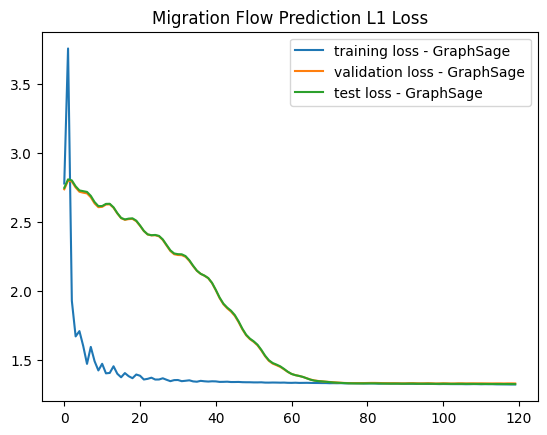

In [47]:
run_pipeline(args_GraphSage)

In [23]:
outcome = torch.cat([test_data.pos_edge_label, test_data.neg_edge_label]).cpu().detach().numpy()
mean_pred = outcome.mean()

In [24]:
outcome.shape

(32269,)

In [26]:
pred_tensor = torch.tensor(np.array([mean_pred] * 32269), dtype=torch.float32)
outcome_tensor = torch.tensor(outcome, dtype=torch.float32)

# Calculate R2 score
r2 = r2_score(pred_tensor, outcome_tensor)
print(r2)

tensor(0.)
